# Figure SX - Constructs

In [2]:
# load external dependencies
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation
import brewer2mpl

# load internal dependencies
import colors,plot,stats,utils

%load_ext autoreload
%autoreload 2

# absolute file path for data directory
dir_data = "/Users/ivg/projects/yeast-cancer-drugs/paper/science/submission/data/"
dir_paper = "/Users/ivg/projects/yeast-cancer-drugs/paper/science/submission/manuscript/main/"
dir_supp = "/Users/ivg/projects/yeast-cancer-drugs/paper/science/submission/manuscript/supp/"

In [8]:
# load data
pheno_df = utils.load_data(dir_data+'pheno/pheno_populations_norm.pickle')

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.background == 'parents')|\
                    (pheno_df.background == 'constructs')|\
                    ((pheno_df.background == 'evolved')&(pheno_df.population == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.env_evo == 'HU')&(pheno_df.prop_rep == 2)&\
                     (pheno_df.isolate == 2)&(pheno_df.genotype_long == 'rnr2*/RNR2'))|\
                    ((pheno_df.background == 'evolved')&(pheno_df.population == 'WAxNA')&\
                     (pheno_df.cross == 'F12')&(pheno_df.cross_rep == 2)&\
                     (pheno_df.env_evo == 'RM')&(pheno_df.prop_rep == 2)&\
                     (pheno_df.isolate == 6)&(pheno_df.genotype_long == 'tor1*/TOR1'))]

pheno_df = pheno_df.replace('WAxNA','WA/NA')

# pheno_df['genotype'] = pheno_df['genotype'].map(lambda x: x.encode('utf-8'))

# duplicate shared controls by candidate gene
groups_1 = pheno_df.groupby(['env_evo','env_test','gene','population'])
for (ii,((env_evo, env_test, gene, population),g1)) in enumerate(groups_1):
    
    if gene!='':
        df = groups_1.get_group((env_evo, env_test,'', population))        
        df = df.replace([env_evo, env_test,'', population],[env_evo, env_test,gene, population])
        
        pheno_df = pheno_df.append(df)

pheno_df = pheno_df[pheno_df.gene != '']

pheno_df.head()  # show dataframe header to stdout

,env_evo,env_test,run,Index,Plate,Row,Column,ID,ID_plate,background,...,assignment,isolate,gene,genotype_short,genotype_long,aminoacid,mating,auxotrophy,doubling_time,growth_rate
466,RM,RM,1,466,0,9,34,P10_C9,10,constructs,...,,,YNR066c,,ynr066cΔ,,MATa,,0.497132,0.708514
470,RM,RM,1,470,0,9,38,P10_C10,10,constructs,...,,,YNR066c,,ynr066cΔ,,MATa,,-0.182682,1.134992
474,RM,RM,1,474,0,9,42,P10_C11,10,constructs,...,,,YNR066c,,ynr066cΔ WA/YNR066c NA,,MATa/α,,0.161159,0.894306
478,RM,RM,1,478,0,9,46,P10_C12,10,constructs,...,,,YNR066c,,YNR066c WA/ynr066cΔ NA,,MATa/α,,0.237700,0.848097
562,RM,RM,1,562,0,11,34,P10_C9,10,constructs,...,,,YNR066c,,ynr066cΔ,,MATa,,0.317800,0.802292


In [11]:
from scipy import stats


tests = {
u'CTF8':{
(u'WA', u'ctf8Δ'): (u'WA', u'WT'),
(u'NA', u'ctf8Δ'): (u'NA', u'WT'),
(u'WA/NA', u'ctf8Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'CTF8 WA/ctf8Δ NA'): (u'WA/NA', u'ctf8Δ WA/CTF8 NA')
},
u'DEP1':{
(u'WA', u'dep1Δ'): (u'WA', u'WT'),
(u'NA', u'dep1Δ'): (u'NA', u'WT'),
(u'WA/NA', u'dep1Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'DEP1 WA/dep1Δ NA'): (u'WA/NA', u'dep1Δ WA/DEP1 NA')
},
u'FPR1':{
(u'WA', u'fpr1Δ'): (u'WA', u'WT'),
(u'NA', u'fpr1Δ'): (u'NA', u'WT'),
(u'WA/WA', u'fpr1Δ/FPR1'): (u'WA/WA', u'WT'),
(u'NA/NA', u'fpr1Δ/FPR1'): (u'NA/NA', u'WT'),
(u'WA/NA', u'fpr1Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'FPR1 WA/fpr1Δ NA'): (u'WA/NA', u'fpr1Δ WA/FPR1 NA')
},
u'INP54':{
(u'WA', u'inp54Δ'): (u'WA', u'WT'),
(u'NA', u'inp54Δ'): (u'NA', u'WT'),
(u'WA/NA', u'inp54Δ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'INP54 WA/inp54Δ NA'): (u'WA/NA', u'inp54Δ WA/INP54 NA')
},
u'KOG1':{
(u'WA/NA', u'KOG1 WA/kog1Δ NA'): (u'WA/NA', u'kog1Δ WA/KOG1 NA')
},
u'RNR2':{
(u'WA', u'rnr2Δ'): (u'WA', u'WT'),
(u'NA', u'rnr2Δ'): (u'NA', u'WT'),
(u'WA/WA', u'rnr2Δ/RNR2'): (u'WA/WA', u'WT'),
(u'NA/NA', u'rnr2Δ/RNR2'): (u'NA/NA', u'WT'),
(u'WA/NA', u'rnr2*Δ/RNR2'): (u'WA/NA', u'RNR2*/rnr2Δ'),
(u'WA/NA', u'RNR2 WA/rnr2Δ NA'): (u'WA/NA', u'rnr2Δ WA/RNR2 NA')
},
u'RNR4':{
(u'WA', u'rnr4Δ'): (u'WA', u'WT'),
(u'NA', u'rnr4Δ'): (u'NA', u'WT'),
(u'WA/WA', u'rnr4Δ/RNR4'): (u'WA/WA', u'WT'),
(u'NA/NA', u'rnr4Δ/RNR4'): (u'NA/NA', u'WT'),
(u'NA/NA', u'rnr4::RNR4*'): (u'NA/NA', u'WT'),
(u'WA/NA', u'RNR4 WA/rnr4Δ NA'): (u'WA/NA', u'rnr4Δ WA/RNR4 NA')
},
u'TOR1':{
(u'WA', u'tor1Δ'): (u'WA', u'WT'),
(u'NA', u'tor1Δ'): (u'NA', u'WT'),
(u'WA/WA', u'tor1Δ/TOR1'): (u'WA/WA', u'WT'),
(u'NA/NA', u'tor1Δ/TOR1'): (u'NA/NA', u'WT'),
(u'WA/NA', u'tor1*Δ/TOR1'): (u'WA/NA', u'TOR1*/tor1Δ'),
(u'WA/NA', u'TOR1 WA/tor1Δ NA'): (u'WA/NA', u'tor1Δ WA/TOR1 NA')
},
u'YNR066c':{
(u'WA', u'ynr066cΔ'): (u'WA', u'WT'),
(u'NA', u'ynr066cΔ'): (u'NA', u'WT'),
(u'WA/NA', u'ynr066cΔ'): (u'WA/NA', u'WT'),
(u'WA/NA', u'YNR066c WA/ynr066cΔ NA'): (u'WA/NA', u'ynr066cΔ WA/YNR066c NA')
}
}

stattest=[]

param='growth_rate'


for ((env_evo,env_test,gene),geeg) in pheno_df.groupby(['env_evo','env_test','gene']):
    for ((background,genotype),gbg) in geeg.groupby(['population','genotype_long']):
        if (background,genotype) in tests[gene]:
            wt=tests[gene][(background,genotype)]#
            mut=(background,genotype)
            wt_data = geeg.groupby(['population','genotype_long']).get_group(wt)[param]
            mut_data = geeg.groupby(['population','genotype_long']).get_group(mut)[param]
            wt_data = wt_data.dropna().tolist()
            mut_data = mut_data.dropna().tolist()
            x_min=min(wt_data+mut_data)
            x_max=max(wt_data+mut_data)
            z_stat,p_val = stats.ranksums(wt_data,mut_data)
            stattest.append([env_evo,env_test,gene,
                             wt,mut,x_min,x_max,
                             z_stat,p_val,utils.stars(p_val)])

stattest = pd.DataFrame(stattest,columns=('env_evo','env_test','gene',
                                          'wt','mut','min','max',
                                          'z_stat','p_val','stars'))

stattest_to_file = stattest.sort(['gene','env_evo', 'env_test','p_val'])
stattest_to_file['wt'] = pd.Series(','.join(k) for k in stattest_to_file['wt'])
stattest_to_file['mut'] = pd.Series(','.join(k) for k in stattest_to_file['mut'])
stattest_to_file.set_index(['gene','env_evo','env_test']).to_excel(dir_supp+\
                                                                   'Tables/TableSX_pheno_constructs.xls',
                                                                   columns=['wt','mut','z_stat','p_val','stars'])

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:91: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [12]:
from pytools import colors

hatches = []

from matplotlib.collections import PatchCollection
from matplotlib import lines
from matplotlib.patches import Polygon

def boxplot_custom(bp, ax, colors=colors, hatches=hatches):
    for i in range(len(bp['boxes'])):
        box = bp['boxes'][i]
        box.set_linewidth(0)
        boxX = []
        boxY = []
        for j in range(5):
            boxX.append(box.get_xdata()[j])
            boxY.append(box.get_ydata()[j])
            boxCoords = zip(boxX,boxY)
            boxPolygon = Polygon(boxCoords, 
                                 facecolor = colors[i % len(colors)], 
                                 linewidth=0, 
                                 hatch = hatches[i % len(hatches)])
            ax.add_patch(boxPolygon)

    for i in range(0, len(bp['boxes'])):
        bp['boxes'][i].set_color(colors[i])
        #bp['boxes'][i].set_hatch('/')

        # we have two whiskers!
        bp['whiskers'][i*2].set(color=colors[i], 
                                linewidth=1.5,
                                linestyle='-')
        bp['whiskers'][i*2 + 1].set(color=colors[i], 
                                linewidth=1.5,
                                linestyle='-')
        # top and bottom fliers
        bp['fliers'][i].set(markerfacecolor=colors[i],
                            marker='o', alpha=0.75, markersize=3,
                            markeredgecolor='none')
        bp['medians'][i].set_color('black')
        bp['medians'][i].set_linewidth(2)
        # and 4 caps to remove
        for c in bp['caps']:
            c.set_linewidth(0)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='y', length=0)

    ax.grid(axis='y', color="0.9", linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    
def set_custom_labels(index, pos):
    """
    
    """
    start = dict((m[pos], ii) for ii,m in enumerate(index.values))
    end = dict((m[pos], len(index)-ii-1) for ii,m in enumerate(index[::-1].values))
    labels = {key: (start[key] + end.get(key, 0))/2. for key in end.keys()}
    
    return start, end, labels

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


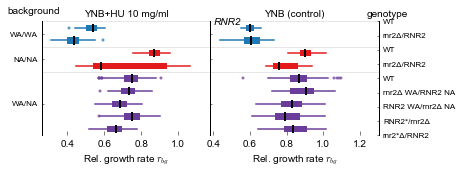

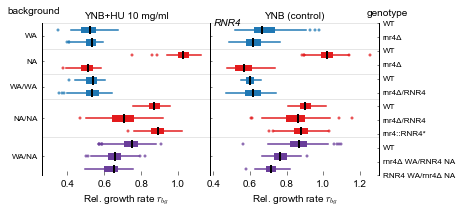

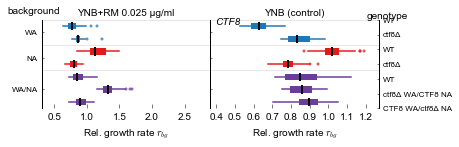

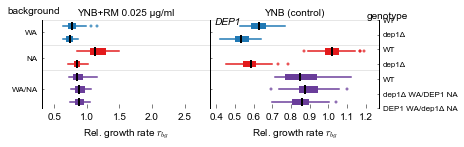

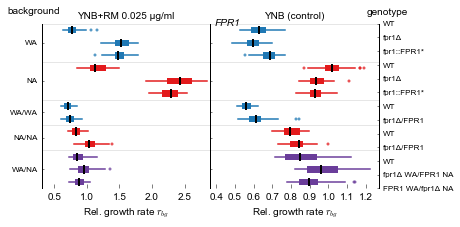

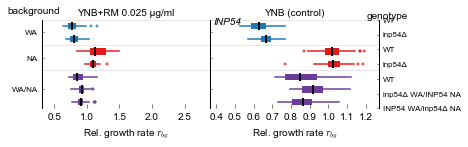

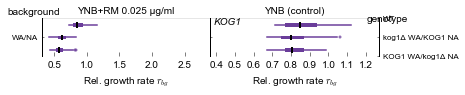

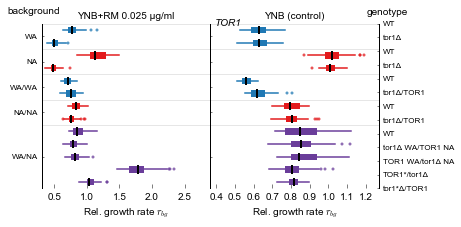

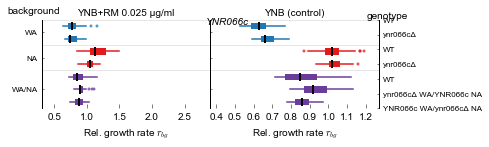

In [15]:
param = 'growth_rate'

color = brewer2mpl.get_map('Paired', 'qualitative', 12).mpl_colors

# background attributes
position_background = {'WA':0, 'NA':1, 'WA/WA':2, 'NA/NA':3, 'WA/NA':4}
color_background_wt = {'WA':color[0], 'NA':color[4], 'WA/WA':color[0], 'NA/NA':color[4], 'WA/NA':color[8]}
color_background_mut = {'WA':color[1], 'NA':color[5], 'WA/WA':color[1], 'NA/NA':color[5], 'WA/NA':color[9]}

# genotype attributes
position_genotype = {
'HU': {u'RNR2':{u'WT':0, u'rnr2Δ':1, u'rnr2Δ/RNR2':2, u'rnr2::RNR2*':3,
                u'rnr2Δ WA/RNR2 NA':4, u'RNR2 WA/rnr2Δ NA':5,
                u'RNR2*/rnr2Δ':6, u'rnr2*Δ/RNR2':7}, 
       u'RNR4':{u'WT':0, u'rnr4Δ':1, u'rnr4Δ/RNR4':2,
                u'rnr4Δ WA/RNR4 NA':3, u'RNR4 WA/rnr4Δ NA':4, u'rnr4::RNR4*':5}},
'RM': {u'CTF8':{u'WT':0, u'ctf8Δ':1,
                u'ctf8Δ WA/CTF8 NA':2, u'CTF8 WA/ctf8Δ NA':3}, 
       u'DEP1':{u'WT':0, u'dep1Δ':1,
                u'dep1Δ WA/DEP1 NA':2, u'DEP1 WA/dep1Δ NA':3},
       u'FPR1':{u'WT':0, u'fpr1Δ':1, u'fpr1Δ/FPR1':2,
                u'fpr1Δ WA/FPR1 NA':3, u'FPR1 WA/fpr1Δ NA':4, u'fpr1::FPR1*':5},
       u'INP54':{u'WT':0, u'inp54Δ':1,
                 u'inp54Δ WA/INP54 NA':2, u'INP54 WA/inp54Δ NA':3}, 
       u'KOG1':{u'WT':0, u'kog1Δ WA/KOG1 NA':1, u'KOG1 WA/kog1Δ NA':2},
       u'TOR1':{u'WT':0, u'tor1Δ':1, u'tor1Δ/TOR1':2, 
                u'tor1Δ WA/TOR1 NA':3, u'TOR1 WA/tor1Δ NA':4, 
                u'TOR1*/tor1Δ':5, u'tor1*Δ/TOR1':6},
       u'YNR066c':{u'WT':0, u'ynr066cΔ':1,
                   u'ynr066cΔ WA/YNR066c NA':2, u'YNR066c WA/ynr066cΔ NA':3}}
}

# environment attributes
environments = {u'HU': u'YNB+HU 10 mg/ml', 
                u'RM': u'YNB+RM 0.025 μg/ml', 
                u'YNB': u'YNB (control)'}

for (ii, ((env_evo), gph1)) in enumerate(pheno_df.groupby(['env_evo'])):

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    
    # calculate axes limits
    (xmin, xmax, ymin, ymax) = range(0, 4)    
    xmin = gph1.groupby('env_test')[param].min()
    xmax = gph1.groupby('env_test')[param].max()
        
    for (jj, ((gene), gph2)) in enumerate(gph1.groupby(['gene'])):
        
        
        gph2.loc[:,'rank_background'] = gph2['population'].map(position_background)
        gph2.loc[:,'rank_genotype'] = gph2['genotype_long'].map(position_genotype[env_evo][gene])
        gph2.sort_values(['rank_background','rank_genotype'], 
                         ascending=[False,False], inplace=True)
        
        nrows=len(gph2.groupby(['population','genotype_long']))
        ncols=len(gph2.groupby(['env_test']))
        
        height, width = np.array([nrows*0.2, ncols*3], dtype=float)
        
        fig, axes = plt.subplots(1, 2, figsize=(width, height), dpi=300, sharey=True)
        
        fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,wspace=0)

        plt.suptitle(gene, fontsize=10, style='italic', ha='center', va='top')##y=1.05)
    
        for (kk, ((env_test), gph3)) in enumerate(gph2.groupby('env_test')):
            
            ax1 = axes[kk]
            ax2 = ax1.twinx()

            gph3 = gph3.set_index(['population','genotype_long'], append=True)[param]\
            .unstack(['population','genotype_long'])
            
            # boxplot
            ax1, bp = gph3.plot(ax=ax1, kind='box',vert=False, return_type='both',
                                labels=gph3.columns.get_level_values('population'))
        
            boxplot_custom(bp, ax1,
                           colors=[color_background_mut[b] for b in gph3.columns.get_level_values('population')],
                           hatches=['']*30)
            
#         stars=stattest[(stattest.p_val<1e-3)&(stattest.env_evo==env_evo)&\
#                        (stattest.env_test==env_test)&(stattest.mut==(background,genotype))]
#         if len(stars)>0:
#             y_min=idx
#             y_max=idx+1
#             x_min=stars['min']
#             x_max=stars['max']
#             ax1.annotate("", xy=(x_max+0.1, y_min), xycoords='data',
#                          arrowprops=dict(arrowstyle="-", ec='#aaaaaa',
#                                          connectionstyle="bar,fraction=-0.3"))
#             ax1.text(x_max+0.15, y_min+abs(y_max - y_min)*0.3, 
#                      stars['stars'].values[0],
#                      ha='left', va='center')
            
            # set title
            ax1.set_title(environments[env_test], fontsize=10)
            # set axes labels
            ax1.set_xlabel(r'Rel. growth rate $r_{bg}$', fontsize=10)
            # set limits
            for ax in [ax1,ax2]:
                ax.set_xlim((xmin[env_test]-.05,xmax[env_test]+.05))
            # reset ticks
            for ax in [ax1,ax2]:
                ax.set_yticks([])
                ax.set_yticklabels([])

            ## background
            ystart, yend, ylabels = set_custom_labels(gph3.columns, 0)
            
            # grid
            ygrid=[yst+1.5 for yst in list(set(ystart.values()))]
            [ax1.axhline(g, lw=1, ls="-", color="0.9") for g in ygrid]
    
            if ax1.is_first_col():
                
                ax1.set_ylabel('background', transform=ax1.transAxes, fontsize=10, rotation=0)
                ax1.yaxis.set_label_coords(-0.05, 1.05)
                # labels
                ax1.set_yticks([y+1 for y in ylabels.values()], minor=True)
                ax1.set_yticklabels(ylabels.keys(), minor=True, fontsize=8)

            ## genotype
            
            if ax2.is_last_col():
                
                ax2.set_ylabel('genotype', transform=ax2.transAxes, fontsize=10, rotation=0)
                ax2.yaxis.set_label_coords(1.05, 1.1)
                # labels
                ylabels = gph3.columns.get_level_values('genotype_long')
                ax2.set_yticks([])
                ax2.set_yticklabels([])
                ax2.set_yticks([y for y in np.arange(len(ylabels))], minor=True)
                ax2.set_yticklabels(['/'.join(y) if isinstance(y, tuple) else y for y in ylabels], 
                                    minor=True, fontsize=8)

#         ax.tick_params(axis='x', which='minor', size=0, pad=-6)
#         ax.tick_params(axis='x', which='major', size=0, pad=3)

        # tweak axes
        for ax in fig.get_axes():
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.get_xaxis().tick_bottom()
            
#             if ax.is_first_col():
#                 ax.get_yaxis().tick_left()
#                 ax.tick_params(axis='y', which='major', labelsize=5)
#             if ax.is_last_col():
#                 ax.get_yaxis().tick_right()
#                 ax.tick_params(axis='y', which='minor', labelsize=5)

    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.png' % gene, 
                dpi=300, bbox_inches='tight')
    fig.savefig(dir_supp+'figures/figureSX_pheno_constructs/figureSX_pheno_constructs_%s.svg' % gene, 
                dpi=300, bbox_inches='tight')
plt.show()

In [198]:
for (ii, ((env_evo), gph1)) in enumerate(pheno_df.groupby(['env_evo'])):

    # remove NaNs
    gph1 = gph1[np.isfinite(gph1[param])]
    
    # calculate axes limits
    (xmin, xmax, ymin, ymax) = range(0, 4)    
    xmin = gph1.groupby('env_test')[param].min()
    xmax = gph1.groupby('env_test')[param].max()
        
    print gph1.shape

(4942, 45)
(7255, 45)


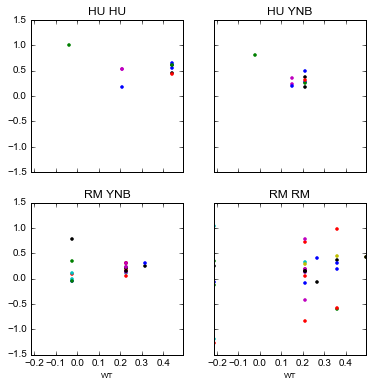

In [393]:
g3 = g2.reset_index()
g3.subtract(g3['WT'], axis=0)#.unstack(['background','gene'])#.plot()

genotype   WT   rnr4Δ                                                   \
env_evo            RM                                                    
env_test           RM                                                    
background         WA      NA   WA/NA   WA   NA WA/WA NA/NA WA/NA   WA   
gene          YNR066c YNR066c YNR066c FPR1 FPR1  FPR1  FPR1  FPR1 TOR1   
0           0     NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN  NaN   
1           0     NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN  NaN   
2           0     NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN  NaN   
3           0     NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN  NaN   
4           0     NaN     NaN     NaN  NaN  NaN   NaN   NaN   NaN  NaN   

genotype      ...    CTF8 WA/ctf8Δ NA                                         \
env_evo       ...                  RM                                          
env_test      ...                  RM                                          
background    ...                  WA   NA WA/NA    WA    NA WA/NA        WA   
gene          ...                DEP1 DEP1  DEP1 INP54 INP54 INP54 KOG1 CTF8   
0             ...                 NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   
1             ...                 NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   
2             ...                 NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   
3             ...                 NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   
4             ...                 NaN  NaN   NaN   NaN   NaN   NaN  NaN  NaN   

genotype                   
env_evo                    
env_test                   
background   NA     WA/NA  
gene       CTF8      CTF8  
0           NaN       NaN  
1           NaN -0.051618  
2           NaN       NaN  
3           NaN       NaN  
4           NaN       NaN  

[5 rows x 806 columns]

In [326]:
# gph2
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'A':[1,2,3,4,5,6],'B':[2,0,3,6,1,3],'C':[7,3,2,1,5,0],'D':[1,3,0,2,2,6]})

col = 'A'
# df2 = df.drop(col,axis=1)
# df2.index = df[col]
# df2.plot(subplots=True, style='.')
# plt.legend(loc='best')
# plt.show()

con2#.drop(col,axis=1)

genotype,CTF8 WA/ctf8Δ NA,DEP1 WA/dep1Δ NA,FPR1 WA/fpr1Δ NA,INP54 WA/inp54Δ NA,KOG1 WA/kog1Δ NA,RNR2 WA/rnr2Δ NA,RNR2*/rnr2Δ,RNR4 WA/rnr4Δ NA,TOR1 WA/tor1Δ NA,TOR1*/tor1Δ,...,rnr4::RNR4*,rnr4Δ,rnr4Δ WA/RNR4 NA,rnr4Δ/RNR4,tor1*Δ/TOR1,tor1Δ,tor1Δ WA/TOR1 NA,tor1Δ/TOR1,ynr066cΔ,ynr066cΔ WA/YNR066c NA
WT,,,,,,,,,,,,,,,,,,,,,
-0.036848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.000334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.206436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.179880,NaN,NaN,0.526294,NaN,NaN,NaN,NaN,NaN,NaN
0.960844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.940279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.440472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.655815,NaN,NaN,...,NaN,NaN,0.617178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.925609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.921560,NaN,NaN,NaN,NaN,NaN,NaN
0.206436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.440472,NaN,NaN,NaN,NaN,NaN,0.561892,0.438788,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.925609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0.024105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.805069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [306]:
con

genotype                             CTF8 WA/ctf8Δ NA  DEP1 WA/dep1Δ NA  \
env_evo env_test gene    background                                       
HU      HU       RNR4    NA                       NaN               NaN   
                         NA/NA                    NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
                 RNR2    NA/NA                    NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
        YNB      RNR4    NA                       NaN               NaN   
                         NA/NA                    NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
                 RNR2    NA/NA                    NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
RM      YNB      YNR066c NA                       NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                 FPR1    NA                       NaN               NaN   
                         NA/NA                    NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
                 TOR1    NA                       NaN               NaN   
                         NA/NA                    NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
                 DEP1    NA                       NaN               NaN   
...                                               ...               ...   
                 INP54   NA                       NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                 KOG1    WA/NA                    NaN               NaN   
                 CTF8    NA                       NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA               0.157919               NaN   
        RM       YNR066c NA                       NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                 FPR1    NA                       NaN               NaN   
                         NA/NA                    NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
                 TOR1    NA                       NaN               NaN   
                         NA/NA                    NaN               NaN   
                         WA                       NaN               NaN   
                         WA/NA                    NaN               NaN   
                         WA/WA                    NaN               NaN   
                 DEP1    

In [ ]:
def annotate_boxplot(bp):
    for i in range(0, len(bp['boxes'])):
    # get position data for median line
    x, y = bp['whiskers'][i*2].get_xydata()[1] # top of median line
    # overlay median value
    text(x-.2, y-.1, 'n=%i' % len(g2[param].values),
        horizontalalignment='left') # draw above, centered